<a href="https://colab.research.google.com/github/SANS-Surya-o/Atlas/blob/main/bonus/Node2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kindly do not 'run all' until cells 1-5 run without errors (to ensure all requirements are correclty installed)

In [7]:
import torch
print(torch.__version__)

2.5.1+cu124


In [6]:
# Run this cell if the output from the previous cell is not 2.5.1
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124


SyntaxError: invalid syntax (<ipython-input-6-186302c24da9>, line 2)

In [8]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.5.0+cu124.html
!pip install torch_geometric


Looking in links: https://data.pyg.org/whl/torch-2.5.0+cu124.html


In [9]:
import torch_cluster
print("torch-cluster version:", torch_cluster.__version__)

torch-cluster version: 1.6.3+pt25cu124


In [10]:
!pip install iso3166

# Dataset creation

Import the dataset into a networkx graph. This task is implemented only for the country graph.
#### NOTE:
 Isolated nodes in the training set are bad.
 They do not get embedded by defualt in node2vec (as it can not generate a context for isolated nodes).
 So, such nodes cause an error when an edge pops up in the test set and the program looks for a non-existant embedding for calculating the dot similarity causing a crash..
 If the algorithm is forced to make an embedding by specifying the num_nodes param, the random intialised values stick till the end and cause poor prediction.

 I could not find a convincing solution and so let these nodes be.

In [11]:
import networkx as nx
import torch
import numpy as np
from torch_geometric.utils import from_networkx, train_test_split_edges, negative_sampling, add_self_loops
from torch_geometric.nn import Node2Vec
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import iso3166

countries = [county.name for county in iso3166.countries]
refined_countries = []
# 1. remove countries with non-alphabetic characters
for country in countries:
    if all(x.isalpha() or x.isspace() for x in country):
        refined_countries.append(country.lower())

countries = refined_countries

# Later: Add cities also


G = nx.DiGraph()
G.add_nodes_from(countries)
for a in countries:
    for b in countries:
        if a != b and a[-1].lower() == b[0].lower():
            G.add_edge(a, b)

# G is modified in place - maintain a copy
G_copy = G.copy()
node_mapping = {i: country for i, country in enumerate(G.nodes())}


data = from_networkx(G)
data = train_test_split_edges(data, val_ratio=0.05, test_ratio=0.1)


# # Negative edges
# data.train_neg_edge_index = negative_sampling(
#     edge_index=data.train_pos_edge_index,  # Training positive edges
#     num_nodes=data.num_nodes,
#     num_neg_samples=data.train_pos_edge_index.shape[1]  # Same number as positive edges
# )

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [12]:
print(G_copy)

DiGraph with 227 nodes and 2897 edges


In [13]:
print(f"Total Number of nodes: {G.number_of_nodes()}")
print(f"Total Number of edges: {G.number_of_edges()}")
print(f"Training edges positive: {data.train_pos_edge_index.shape[1]}")
# print(f"Training edges negative: {data.train_neg_edge_index.shape[1]}")
print(f"Validation edges positive: {data.val_pos_edge_index.shape[1]}")
print(f"Validation edges negative: {data.val_neg_edge_index.shape[1]}")
print(f"Testing edges positive: {data.test_pos_edge_index.shape[1]}")
print(f"Testing edges negative: {data.test_neg_edge_index.shape[1]}")

Total Number of nodes: 227
Total Number of edges: 2897
Training edges positive: 2044
Validation edges positive: 60
Validation edges negative: 60
Testing edges positive: 120
Testing edges negative: 120


# Model Defintion

In [26]:
# Set hyperparameters for Node2Vec
embedding_dim = 64
context_size = 10
walk_length = 20
walks_per_node = 20
p=0.5
q=2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create the Node2Vec model using PyG's implementation.
model = Node2Vec(
    data.train_pos_edge_index,  # use training edges only for the unsupervised objective
    embedding_dim=embedding_dim,
    walk_length=walk_length,
    context_size=context_size,
    walks_per_node=walks_per_node,
    p=p,q=q,
    sparse=True,
    num_nodes=data.num_nodes
).to(device)


####  NOTE: Did not have time to carry out many experiments. The below is link to an excel with experiments possibly carried out after deadline. Run with the latest Hyperparameters for best results.
https://docs.google.com/spreadsheets/d/1j4bxt7AWX_v881EpTVL8TTilUQBsFasm8gVwFZbpTQo/edit?usp=sharing


##  Hyperparameter selection

The graph is relatively small with 250 nodes. There is no noise.

### 1. Embedding Dimensions

Can afford higher embedding dimensions with reasonable training times. However, by the very same virtue of small size and the fact that the nodes are not feature rich (the rule is simple), we may not need very high embedding. No need to overparamterise for a simple graph.

64 - 128 seems resonable.

### 2. Context Size
10 is almost like an industry standard..

### 3. Walk Length
Short walks preferred. As the size increases, walk ventures into irrelevant nodes.

### 4. Walks per node
Begin with 20, may explore higher number if training permits


### 5. p (Return Parameter), q (In-out parameter)
Begin with an unbiased walk(p=1,q=1) and experiment. Lower p induces BFS like properties(better captures structural equivalence), and q induces DFS like properties (captures Homophily).
Structural Equivalence seems insignificant for the current use case.. Therefore, lower p, higher q seems reasonable (kindly refer to the sheet for future experiments).






In [27]:
loader = model.loader(batch_size=64, shuffle=True, num_workers=2)

In [28]:
for idx, (pos_rw, neg_rw) in enumerate(loader):
    print(idx, pos_rw.shape, neg_rw.shape)

0 torch.Size([14080, 10]) torch.Size([14080, 10])
1 torch.Size([14080, 10]) torch.Size([14080, 10])
2 torch.Size([14080, 10]) torch.Size([14080, 10])
3 torch.Size([7700, 10]) torch.Size([7700, 10])


In [17]:
pos_rw

tensor([[ 23, 149, 113,  ...,   8,   7,  12],
        [ 48, 177, 131,  ...,  31, 122,  31],
        [171,  39, 191,  ..., 171,  46, 192],
        ...,
        [188,  48, 180,  ..., 125, 172, 191],
        [ 87,  87,  87,  ...,  87,  87,  87],
        [172, 185,  16,  ..., 181, 172, 194]])

# Visualisation (of a random walk)


In [29]:
import networkx as nx
# Make a graph of the training edges
edge_tuples = [tuple(x) for x in data.train_pos_edge_index.numpy().transpose()]
G_dummy = nx.from_edgelist(edge_tuples)
pos = nx.spring_layout(G_dummy, center=[0.5, 0.5])
nx.set_node_attributes(G_dummy, pos, 'pos')

[200, 131, 193, 125, 178, 131, 199, 182, 89, 190]


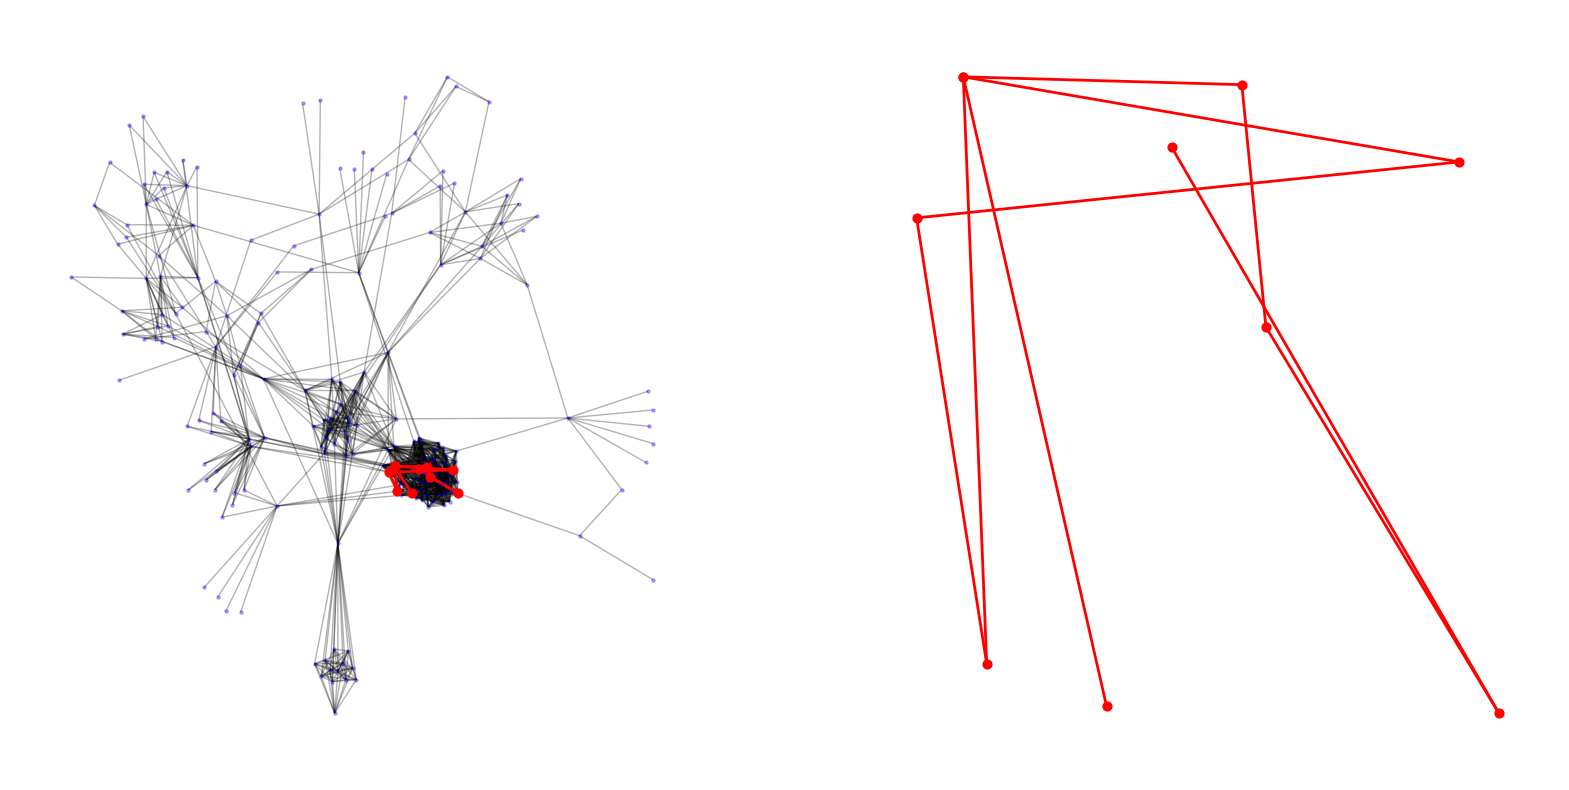

In [30]:

# Visualise random walks...
# Run this multiple times to see the kind of connections the model captures.
# Tweak p,q accordingly.

nodelist = next(enumerate(loader))[1][0][0].tolist()
print(nodelist)
missing_nodes = [node_id for node_id in nodelist if node_id not in pos]
assert(len(missing_nodes) == 0) # If this fails, something is wrong

walk = nx.path_graph(len(nodelist))
nx.set_node_attributes(walk, {idx: pos[node_id] for idx, node_id in enumerate(nodelist)}, 'pos')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
nx.draw_networkx_nodes(G_dummy,
                       ax=ax,
                       pos=nx.get_node_attributes(G_dummy, 'pos'),
                       node_size=5,
                       alpha=0.3,
                       node_color='b')

nx.draw_networkx_edges(G_dummy,
                       pos,
                       ax=ax,
                       alpha=0.3,
                       width=1
                       )

nx.draw(walk,
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'),
        width=2,
        edge_color='r')
ax = fig.add_subplot(1, 2, 2)
nx.draw(walk,
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'),
        width=2,
        edge_color='r')

# Training and Testing


In [31]:
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [32]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in tqdm(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

## ROC-AUC
#### Receiver Operating Characteristic curve - Area under the curve

The ROC curve is the plot of the true positive rate (TPR) against the false positive rate (FPR) at each threshold setting.
Image: https://cdn.prod.website-files.com/660ef16a9e0687d9cc27474a/662c42677529a0f4e97e4f9c_644aec2628bc14d83ca873a2_class_guide_cm10.png
Basically the threshold at which probability becomes a label is not set in stone. Increasing the threshold probaility would increase both TPR and FPR, the exact area under this curve is the AUC score. A random classifier corresponds to a straight line for which the area would be 0.5, you want the curve more convex: an AUC score more than 0.5 - closer to 1 the better.  

## Why the use of dot product for edge prediction makes sense...

The optimiser is trying to increase the dot similarity between nodes that are likely to be connected; i.e the loss function is higher the more closely connected the nodes are, the more likely they are to be connected by an edge.



In [33]:
from sklearn.metrics import roc_auc_score

@torch.no_grad()
def test():
    model.eval()
    embeddings = model()
    pos_edge_index = data.test_pos_edge_index.to(device)
    # Dot product similarity
    pos_scores = (embeddings[pos_edge_index[0]] * embeddings[pos_edge_index[1]]).sum(dim=1)

    neg_edge_index = data.test_neg_edge_index.to(device)  # (2, num_neg_edges)

    # Dot product similarity
    neg_scores = (embeddings[neg_edge_index[0]] * embeddings[neg_edge_index[1]]).sum(dim=1)

    labels = torch.cat([torch.ones(pos_scores.size(0)), torch.zeros(neg_scores.size(0))]).cpu()
    scores = torch.cat([pos_scores, neg_scores]).cpu()

    auc = roc_auc_score(labels, scores)
    return auc

In [34]:
auc_scores = []
epochs = 100
for epoch in range(1, epochs):
    loss = train()
    acc = test()
    auc_scores.append(acc)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 01, Loss: 6.0516, Acc: 0.5289


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 02, Loss: 5.5434, Acc: 0.5399


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 03, Loss: 5.0110, Acc: 0.5535


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 04, Loss: 4.6012, Acc: 0.5697


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 05, Loss: 4.2388, Acc: 0.5849


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 06, Loss: 3.9309, Acc: 0.6008


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 07, Loss: 3.6011, Acc: 0.6231


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 08, Loss: 3.3731, Acc: 0.6408


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 09, Loss: 3.1397, Acc: 0.6622


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 10, Loss: 2.9677, Acc: 0.6827


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 11, Loss: 2.8127, Acc: 0.6978


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 12, Loss: 2.6768, Acc: 0.7160


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 13, Loss: 2.5584, Acc: 0.7294


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 14, Loss: 2.4315, Acc: 0.7415


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 15, Loss: 2.3387, Acc: 0.7518


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 16, Loss: 2.2366, Acc: 0.7598


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 17, Loss: 2.1584, Acc: 0.7677


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 18, Loss: 2.0810, Acc: 0.7738


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 19, Loss: 2.0041, Acc: 0.7803


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 20, Loss: 1.9495, Acc: 0.7882


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 21, Loss: 1.8935, Acc: 0.7950


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 22, Loss: 1.8360, Acc: 0.8039


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 23, Loss: 1.7805, Acc: 0.8112


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 24, Loss: 1.7149, Acc: 0.8184


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 25, Loss: 1.6921, Acc: 0.8265


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 26, Loss: 1.6468, Acc: 0.8338


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 27, Loss: 1.6076, Acc: 0.8399


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 28, Loss: 1.5664, Acc: 0.8465


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 29, Loss: 1.5297, Acc: 0.8535


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 30, Loss: 1.4935, Acc: 0.8608


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 31, Loss: 1.4580, Acc: 0.8655


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 32, Loss: 1.4286, Acc: 0.8702


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 33, Loss: 1.4059, Acc: 0.8760


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 34, Loss: 1.3774, Acc: 0.8793


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 35, Loss: 1.3521, Acc: 0.8835


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 36, Loss: 1.3119, Acc: 0.8897


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 37, Loss: 1.3060, Acc: 0.8951


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 38, Loss: 1.2848, Acc: 0.8988


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 39, Loss: 1.2792, Acc: 0.9038


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 40, Loss: 1.2450, Acc: 0.9087


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 41, Loss: 1.2330, Acc: 0.9136


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 42, Loss: 1.2185, Acc: 0.9176


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 43, Loss: 1.2142, Acc: 0.9216


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 44, Loss: 1.1868, Acc: 0.9264


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 45, Loss: 1.1801, Acc: 0.9289


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 46, Loss: 1.1627, Acc: 0.9311


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 47, Loss: 1.1467, Acc: 0.9324


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 48, Loss: 1.1406, Acc: 0.9347


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 49, Loss: 1.1299, Acc: 0.9375


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 50, Loss: 1.1207, Acc: 0.9406


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 51, Loss: 1.1147, Acc: 0.9422


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 52, Loss: 1.0973, Acc: 0.9424


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 53, Loss: 1.0913, Acc: 0.9443


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 54, Loss: 1.0885, Acc: 0.9452


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 55, Loss: 1.0846, Acc: 0.9462


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 56, Loss: 1.0742, Acc: 0.9481


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 57, Loss: 1.0700, Acc: 0.9501


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 58, Loss: 1.0619, Acc: 0.9526


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 59, Loss: 1.0577, Acc: 0.9548


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 60, Loss: 1.0529, Acc: 0.9569


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 61, Loss: 1.0476, Acc: 0.9589


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 62, Loss: 1.0391, Acc: 0.9600


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 63, Loss: 1.0356, Acc: 0.9611


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 64, Loss: 1.0339, Acc: 0.9618


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 65, Loss: 1.0275, Acc: 0.9629


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 66, Loss: 1.0296, Acc: 0.9645


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 67, Loss: 1.0196, Acc: 0.9654


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 68, Loss: 1.0190, Acc: 0.9658


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 69, Loss: 1.0095, Acc: 0.9665


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 70, Loss: 1.0096, Acc: 0.9679


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 71, Loss: 1.0065, Acc: 0.9678


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 72, Loss: 1.0022, Acc: 0.9674


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 73, Loss: 1.0008, Acc: 0.9669


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 74, Loss: 0.9964, Acc: 0.9660


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 75, Loss: 0.9991, Acc: 0.9658


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 76, Loss: 0.9950, Acc: 0.9656


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 77, Loss: 0.9946, Acc: 0.9659


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 78, Loss: 0.9900, Acc: 0.9665


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 79, Loss: 0.9898, Acc: 0.9669


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 80, Loss: 0.9894, Acc: 0.9667


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 81, Loss: 0.9838, Acc: 0.9665


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 82, Loss: 0.9830, Acc: 0.9662


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 83, Loss: 0.9841, Acc: 0.9658


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 84, Loss: 0.9723, Acc: 0.9653


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 85, Loss: 0.9787, Acc: 0.9653


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 86, Loss: 0.9727, Acc: 0.9657


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 87, Loss: 0.9722, Acc: 0.9666


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 88, Loss: 0.9714, Acc: 0.9672


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 89, Loss: 0.9737, Acc: 0.9679


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 90, Loss: 0.9705, Acc: 0.9683


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 91, Loss: 0.9702, Acc: 0.9686


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 92, Loss: 0.9712, Acc: 0.9688


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 93, Loss: 0.9645, Acc: 0.9685


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 94, Loss: 0.9672, Acc: 0.9685


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 95, Loss: 0.9696, Acc: 0.9682


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 96, Loss: 0.9624, Acc: 0.9683


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 97, Loss: 0.9619, Acc: 0.9685


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 98, Loss: 0.9641, Acc: 0.9684


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 99, Loss: 0.9632, Acc: 0.9681


# Visualise Results

In [35]:
emb_128 = model().detach().cpu().numpy()

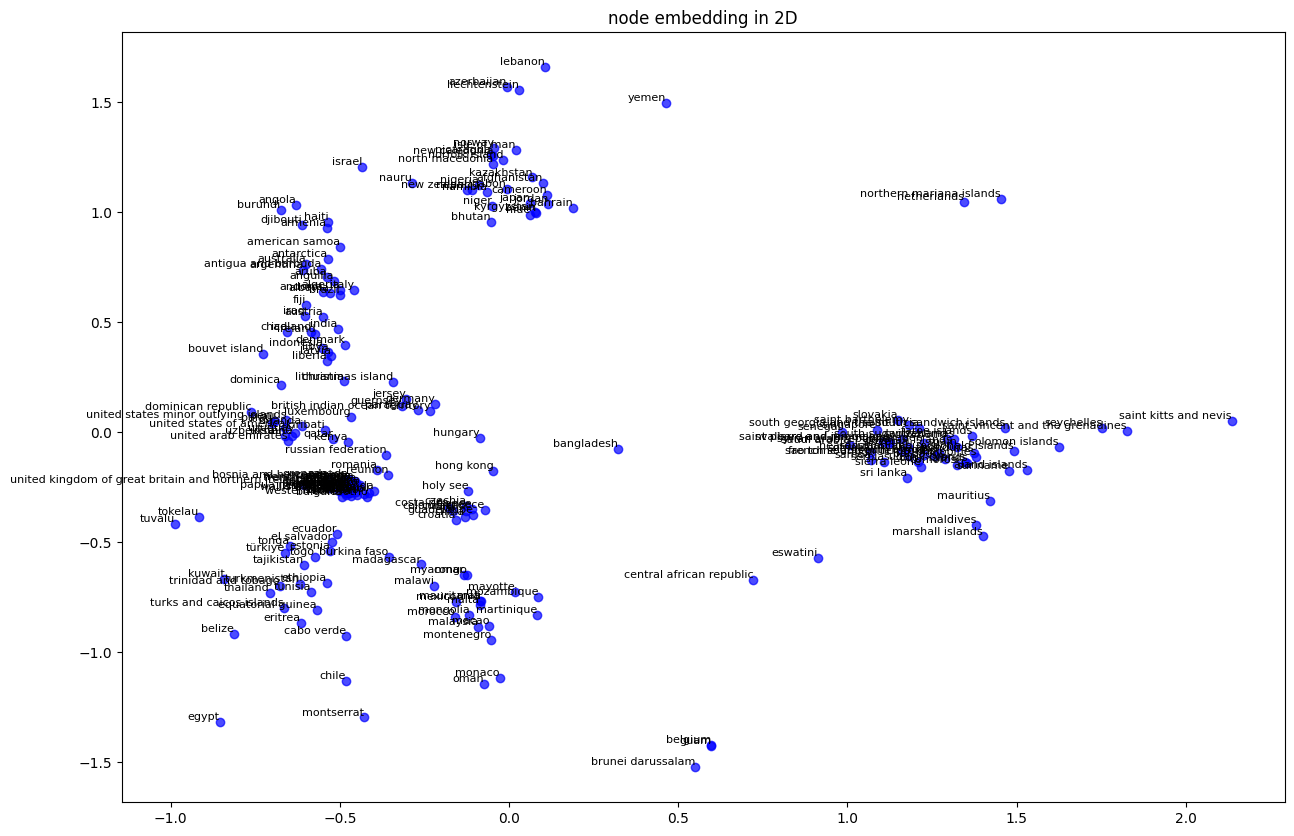

In [36]:
from sklearn.decomposition import PCA
# fit and transform using PCA
pca = PCA(n_components=2)
emb2d = pca.fit_transform(emb_128)

plt.figure(figsize=(15, 10))
plt.title("node embedding in 2D")
for i, (x, y) in enumerate(emb2d):
    plt.scatter(x, y, color='blue', alpha=0.7)
    plt.text(x, y, node_mapping[i], fontsize=8, ha='right', va='bottom')  # Add country labels
plt.show()

In [ ]:
!pip install seaborn
import seaborn as sns


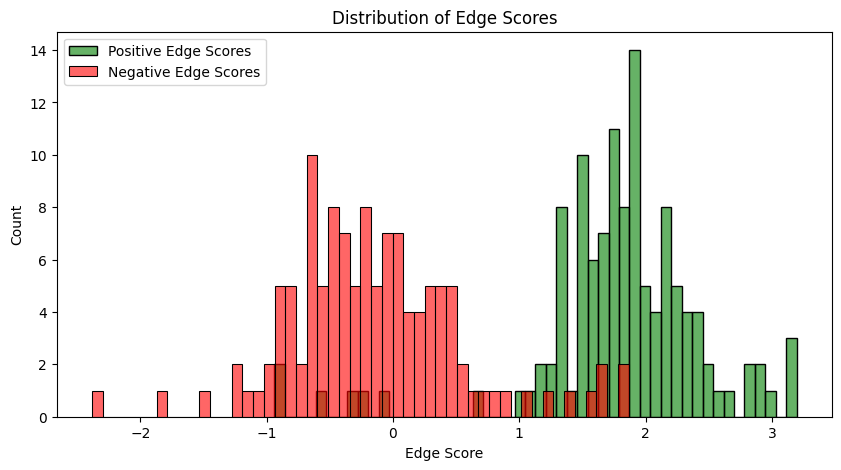

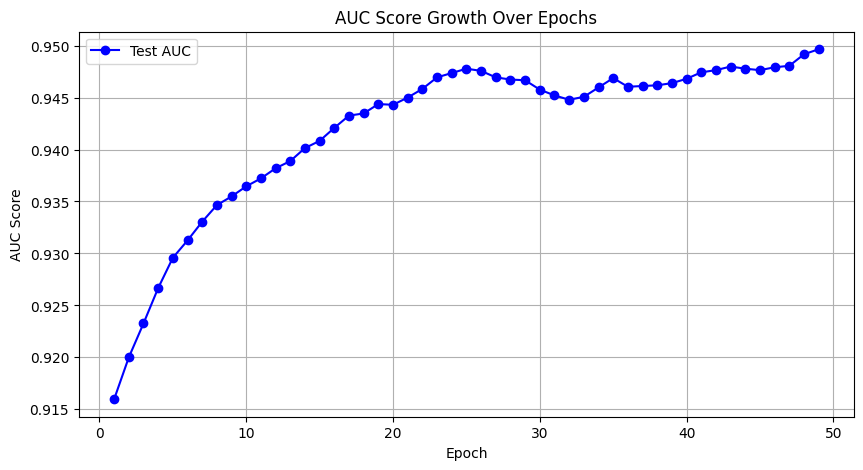

In [ ]:
def visualise_AUC_Growth():
  plt.figure(figsize=(10, 5))
  plt.plot(range(1, epochs), auc_scores, marker='o', linestyle='-', color='b', label="Test AUC")
  plt.xlabel("Epoch")
  plt.ylabel("AUC Score")
  plt.title("AUC Score Growth Over Epochs")
  plt.legend()
  plt.grid()
  plt.show()

@torch.no_grad()
def get_edge_scores():
    model.eval()
    embeddings = model()

    pos_edge_index = data.test_pos_edge_index.to(device)
    neg_edge_index = data.test_neg_edge_index.to(device)

    pos_scores = (embeddings[pos_edge_index[0]] * embeddings[pos_edge_index[1]]).sum(dim=1).cpu().numpy()
    neg_scores = (embeddings[neg_edge_index[0]] * embeddings[neg_edge_index[1]]).sum(dim=1).cpu().numpy()

    return pos_scores, neg_scores

pos_scores, neg_scores = get_edge_scores()

plt.figure(figsize=(10, 5))
sns.histplot(pos_scores, bins=50, color='g', label="Positive Edge Scores", alpha=0.6)
sns.histplot(neg_scores, bins=50, color='r', label="Negative Edge Scores", alpha=0.6)
plt.xlabel("Edge Score")
plt.ylabel("Count")
plt.title("Distribution of Edge Scores")
plt.legend()
plt.show()

visualise_AUC_Growth()

Pending Work:
1. Compare with adamic adar
2. Make it more descriptive and explanatory
3. Hyperparameter tuning
